# 0. Standard imports

In [92]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import copy
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
cd ..

/Users/khalilouardini/Desktop/projects/Cassiopeia_Transcriptome/scvi/external


In [3]:
cd ..

/Users/khalilouardini/Desktop/projects/Cassiopeia_Transcriptome/scvi


In [181]:
%reload_ext autoreload
%matplotlib inline

***import ete3 Tree***

In [5]:
from ete3 import Tree

#tree_name = "/Users/khalilouardini/Desktop/projects/scVI/scvi/data/Cassiopeia_trees/3726_NT_T1_tree.processed.collapsed.tree"
#tree_name = "/Users/khalilouardini/Desktop/projects/scVI/scvi/data/Cassiopeia_trees/tree_test.txt"
#tree = Tree(tree_name, 1)

tree = Tree()
tree.populate(30)

leaves = tree.get_leaves()

for i, n in enumerate(tree.traverse('levelorder')):
    n.add_features(index=i)
    if not n.is_leaf():
        n.name = str(i)

In [240]:
# Data
from anndata import AnnData
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from external.dataset.tree import TreeDataset, GeneExpressionDataset
from external.dataset.poisson_glm import Poisson_GLM
from external.dataset.ppca import PPCA
from external.dataset.anndataset import AnnDatasetFromAnnData

# Models
from models import *;
import scanpy as sc
from external.inference.gaussian_inference import GaussianTrainer
from external.inference.gaussian_tree_inference import GaussianTreeTrainer
from external.inference.gaussian_tree_inference import GaussianTreePosterior
from inference import posterior
from external.models.treevae import TreeVAE
from external.models.gaussian_vae import GaussianVAE
from external.models.gaussian_treevae import GaussianTreeVAE

# Utils
from external.utils.data_util import get_leaves, get_internal
from external.utils.metrics import ks_pvalue, accuracy_imputation, correlations, mse, knn_purity, knn_purity_stratified
from external.utils.plots_util import plot_histograms, plot_scatter_mean, plot_ecdf_ks, plot_density, plot_embedding
from external.utils.plots_util import plot_losses, plot_elbo, plot_common_ancestor, plot_one_gene, training_dashboard
from external.utils.baselines import avg_weighted_baseline, scvi_baseline, scvi_baseline_z, cascvi_baseline_z

# 1. Simulations (Gaussian Likelihood model)

We assume that the latent variables $z \in \mathbb{R}^{N x D}$ are gaussian (correlated). A phylogenetic tree $\tau$ (with $N$ nodes) encodes the covariance $\Sigma$ of $z$. 

$$\mathbf{z}=(z_1, ..., z_N) \sim \mathcal{N}(0, \Sigma)$$

$z$ is partitionned into two groups:

- the leaves $\mathcal{L} = {1, ..., L}$
- the internal nodes $\mathcal{I} = {L + 1, ..., N}$

***

***We describe the generative model***:

Consider a dataset of $ X={x_n}_{n=1}^{L} $ (also partitioned such that $1, ..., N = \mathcal{L} \bigcup \mathcal{I}$) such that $x_n \in \mathbb{R}^{P}$. We aim to represent each $x_n$ under a latent variable $z_n \in \mathbb{R}^{D}$ with  with $D << P$ lower dimension. 
We only observe data at the leaves. the generative model is defined $\forall n \in \mathcal{L}$

The set of principal axes $W$ relates the latent variables to the data.

The corresponding data point is generated via a projection:

$$
\forall n \in \mathcal{L}, x_n =  W z_n + e_n
$$

with $W \in \mathbb{R}^{P x D}$ and $e_n \sim \mathcal{N}(0, \sigma^2 I_P)$. Thus:


$$
\forall n \in \mathcal{L},  x_n | z_n \sim \mathcal{N}(W z_n, \sigma^2 I_P)
$$

After marginalization

$$
\forall n \in \mathcal{L}, x_n \sim \mathcal{N}(0, W^T W + \sigma^2 I_P)
$$

The posterior $p(z_n|x_n)$ for each $n$ is also ***tractable***, indeed

$\begin{pmatrix} x_n \\ z_n \end{pmatrix} = \begin{pmatrix} W z_n + e \\ z_n \end{pmatrix}$ is a gaussian vector (because for $a \in \mathbb{R}$, $b \in \mathbb{R}$, $a(W z_n + e) + bz_n$ is still gaussian) such that:

$$
\begin{pmatrix} x_n \\ z_n \end{pmatrix} \sim \mathcal{N}(\begin{pmatrix} 0 \\ 0 \end{pmatrix}, \begin{pmatrix} W^T W + \sigma^2 I_P  & W\Sigma_n \\ (W\Sigma_n)^T & \Sigma_n \end{pmatrix})
$$

where $\Sigma_n$ is the marginalized covariance $\Sigma$ of $z_n$

Therefore we can use the conditioning formula to infer the mean and the covariance of the (gaussian) posterior $p(z_n|x_n)$:

$$
\mu_{z_n|x_n} = (W\Sigma_{n}(W^{T} W + \sigma^{2} I_{P})^{-1}\Sigma_{n}^{T}W^{T}) x_{n} \\
\Sigma_{z_n|x_n} = \Sigma_n - W\Sigma_{n}(W^{T} W + \sigma^{2} I_{P})^{-1}\Sigma_{n}^{T}W^{T}
$$

***

***Imputation at internal nodes***

Let $j \in \mathcal{I}$, and $X_{\mathcal{L}} = {x_1, ... x_L}$ the set of leaves.
We want to infer $p(x_j|X_{\mathcal{L}})$. If we consider that the data at the internal nodes is "seen" and that the generative model is also known $\forall n \in \mathcal{I}$, we could easily (and accurately) compute $p(x_j|X_{\mathcal{L}})$ by using the gaussian conditioning formula on the gaussian vector:

$$
\begin{pmatrix} x_j \\ X_{\mathcal{L}} \end{pmatrix}
$$

In the case of unseen data at the internal nodes, one can estimate the posterior predictive density:

1. $$
p(x_j|X_{\mathcal{L}}) = p(x_j|x_1, ..., x_L) = \int p(x_j|z_j)p(z_j|z_1,...,z_L)\prod_{i=1}^{L}p(z_i|x_i)(dz_j,dz_1,...,dz_L)
$$

Therefore:
$$
p(x_j|x_1, ..., x_L) \approx  p(x_j|z_j)p(z_j|z_1,...,z_L)\prod_{i=1}^{L}p(z_i|x_i)
$$

$$
p(x_j|x_1, ..., x_L) \approx  \mathcal{N}(x_j|Wz_j, \sigma^2I_P)  \mathcal{N}(z_j|\mu_{j|\mathcal{I}}, \Sigma_{j|\mathcal{I}}) \prod_{i=1}^{L} \mathcal{N}(z_i|\mu_{z_i|x_i}, \Sigma_{z_i|x_i})
$$

2. $ p(x_j|X_{\mathcal{L}}) = Wp(z_j|X_{\mathcal{L}}) + p(e_j)$

In [7]:
print(tree)


         /-aaaaaaaaae
      /-|
     |   \-aaaaaaaaaf
   /-|
  |  |   /-aaaaaaaaag
  |   \-|
  |     |   /-aaaaaaaaah
  |      \-|
  |         \-aaaaaaaaai
  |
  |         /-aaaaaaaaaj
  |      /-|
  |     |  |   /-aaaaaaaaak
  |     |   \-|
--|     |     |   /-aaaaaaaaal
  |   /-|      \-|
  |  |  |         \-aaaaaaaaam
  |  |  |
  |  |  |   /-aaaaaaaaan
  |  |   \-|
  |  |      \-aaaaaaaaao
  |  |
  |  |         /-aaaaaaaaap
  |  |      /-|
  |  |     |   \-aaaaaaaaaq
   \-|   /-|
     |  |  |   /-aaaaaaaaar
     |  |   \-|
     |  |      \-aaaaaaaaas
     |  |
     |  |         /-aaaaaaaaat
     |  |      /-|
     |  |     |  |   /-aaaaaaaaau
     |  |     |   \-|
     |  |     |      \-aaaaaaaaav
      \-|     |
        |   /-|      /-aaaaaaaaaw
        |  |  |   /-|
        |  |  |  |  |   /-aaaaaaaaax
        |  |  |  |   \-|
        |  |  |  |      \-aaaaaaaaay
        |  |  |  |
        |  |   \-|      /-aaaaaaaaaz
        |  |     |   /-|
        |  |     |  |  |   /-aaaaaaaa

In [ ]:
import torch
    
np.random.seed(42)
torch.manual_seed(42)

In [8]:
d = 5
p = 50
vis = True
leaves_only = False
var = 1.0
sigma_scale = 1.0

ppca = PPCA(tree, p, d, vis, leaves_only, var, sigma_scale)

ppca.simulate_latent()

***Marginalization***

In [63]:
ppca.leaves_covariance_z.shape

(150, 150)

In [64]:
ppca.simulate_normal()

In [65]:
lik_tree = ppca.likelihood_obs(leaves_only=False)
lik_leaves = ppca.likelihood_obs(leaves_only=True)

print("Log-Likelihood of the tree {}".format(lik_tree))
print("LogLikelihood of the leaves {}".format(lik_leaves))

Log-Likelihood of the tree -4958.82821706955
LogLikelihood of the leaves -2509.125525809887


***Get data***

In [66]:
# Latent vectors
leaves_z, _, _ = get_leaves(ppca.z, ppca.mu, tree)

#FIXED training set
leaves_X, leaves_idx, mu = get_leaves(ppca.X, ppca.mu, tree)

# internal nodes data (for imputation)
internal_X, internal_idx, internal_mu = get_internal(ppca.X, ppca.mu, tree)

leaves_X.shape, mu.shape, internal_X.shape, internal_mu.shape, leaves_z.shape

((30, 50), (30, 50), (29, 50), (29, 50), (30, 5))

***Posterior Distributions***

evidence

In [67]:
evidence_leaves = ppca.get_evidence_leaves_levelorder(X=ppca.X, dim=ppca.dim)
evidence_leaves.shape

(1500,)

Leaves covariance

In [68]:
ppca.compute_leaves_covariance()

Posterior mean and covariance

In [69]:
posterior_mean, posterior_cov = ppca.compute_posterior()

Posterior predictive density 

In [70]:
predictive_mean, predictive_cov = ppca.compute_posterior_predictive()

## Preliminary: Baselines

***Baseline 1: Unweighted Average of gene expression in Clade***

The simple idea here is to impute the value of an internal node, with the (un)weighted average of the gene expression values of the leaves, taking the query internal node as the root of the subtree.

In [71]:
imputed_avg = avg_weighted_baseline(tree=tree, 
                                    weighted=False, 
                                    X=ppca.X,
                                    rounding=False
                                   )

#get internal nodes
avg_X = np.array([x for x in imputed_avg.values()]).reshape(-1, ppca.X.shape[1])
internal_avg_X, _, _ = get_internal(avg_X, ppca.mu, tree)

***Baseline 2: (groundtruth) posterior predictive density***

In [72]:
imputed_ppca = {}
for n in tree.traverse('levelorder'):
    if not n.is_leaf():
        samples = np.array([np.random.multivariate_normal(mean=predictive_mean[n.name],
                                                            cov=predictive_cov[n.name])
                           for i in range(20)])
        imputed_ppca[n.name] = np.mean(samples, axis=0)

internal_ppca_X = np.array([x for x in imputed_ppca.values()]).reshape(-1, ppca.X.shape[1])

//anaconda3/envs/berkeley/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: covariance is not positive-semidefinite.
  


***Baseline 3: Message Passing Oracle***


i.e, 

1. sample from $z_1, ..., z_n \sim p(z_1, ..., z_n|x_1, ..., x_n)$ (conditionning formula)
2. impute $z_i \sim p(z_i | z_1, ..., z_n)$ (Message Passing)
3. Decode $p(x_i|z_i) = W z_i + \sigma^2 I_P$ (Generative model)

In [73]:
posterior_mean_corr, posterior_cov_corr = ppca.compute_correlated_posterior()

In [74]:
imputed_mp, imputed_z_mp = ppca.compute_approx_posterior_predictive(mean_field=False, use_MP=True)

/Users/khalilouardini/Desktop/projects/Cassiopeia_Transcriptome/scvi/external/dataset/ppca.py:310: RuntimeWarning: covariance is not positive-semidefinite.
  samples_z = np.array([np.random.multivariate_normal(mean=posterior_mean,


go
[2021-04-28 00:11:50,375] WARNING - scvi.dataset.dataset | This dataset has some empty cells, this might fail scVI inference.Data should be filtered with `my_dataset.filter_cells_by_count()
[2021-04-28 00:11:50,376] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2021-04-28 00:11:50,377] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2021-04-28 00:11:50,382] INFO - scvi.dataset.dataset | Merging datasets. Input objects are modified in place.
[2021-04-28 00:11:50,383] INFO - scvi.dataset.dataset | Gene names and cell measurement names are assumed to have a non-null intersection between datasets.
[2021-04-28 00:11:50,383] INFO - scvi.dataset.dataset | Keeping 50 genes
[2021-04-28 00:11:50,384] WARNING - scvi.dataset.dataset | X contains continuous and/or negative values. Please use raw UMI/read counts with scVI
[2021-04-28 00:11:50,385] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2021-04-28 00:11:50,385] WARNING - scvi.dataset.d

In [118]:
imputed_X = np.array([x for x in imputed_mp.values()]).reshape(-1, ppca.X.shape[1])

***Baseline 4: (Mean Field) Message Passing***

i.e, 

1. sample from marginal conditional $z_l \sim p(z_l|x_1) \forall l \in (1, ...,L)$ (conditionning formula)
2. impute $z_i \sim p(z_i | z_1, ..., z_n)$ (Message Passing)
3. Decode $p(x_i|z_i) = W z_i + \sigma^2 I_P$ (Generative model)

In [76]:
imputed_mp2, imputed_z_mp2 = ppca.compute_approx_posterior_predictive(mean_field=True, use_MP=True)

/Users/khalilouardini/Desktop/projects/Cassiopeia_Transcriptome/scvi/external/dataset/ppca.py:316: RuntimeWarning: covariance is not positive-semidefinite.
  for k in list(posterior_mean.keys()):


go
[2021-04-28 00:11:52,332] WARNING - scvi.dataset.dataset | This dataset has some empty cells, this might fail scVI inference.Data should be filtered with `my_dataset.filter_cells_by_count()
[2021-04-28 00:11:52,332] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2021-04-28 00:11:52,333] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2021-04-28 00:11:52,337] INFO - scvi.dataset.dataset | Merging datasets. Input objects are modified in place.
[2021-04-28 00:11:52,338] INFO - scvi.dataset.dataset | Gene names and cell measurement names are assumed to have a non-null intersection between datasets.
[2021-04-28 00:11:52,338] INFO - scvi.dataset.dataset | Keeping 50 genes
[2021-04-28 00:11:52,339] WARNING - scvi.dataset.dataset | X contains continuous and/or negative values. Please use raw UMI/read counts with scVI
[2021-04-28 00:11:52,340] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2021-04-28 00:11:52,341] WARNING - scvi.dataset.d

In [77]:
imputed_X2 = np.array([x for x in imputed_mp2.values()]).reshape(-1, ppca.X.shape[1])

***Baseline 5: Gaussian VAE decoded averaged latent space***

In [226]:
# anndata
gene_dataset = GeneExpressionDataset()
gene_dataset.populate_from_data(leaves_X)

[2021-04-28 15:23:23,671] WARNING - scvi.dataset.dataset | This dataset has some empty cells, this might fail scVI inference.Data should be filtered with `my_dataset.filter_cells_by_count()
[2021-04-28 15:23:23,672] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2021-04-28 15:23:23,672] INFO - scvi.dataset.dataset | Remapping labels to [0,N]


In [228]:
n_epochs = 400

vae = GaussianVAE(gene_dataset.nb_genes,
                  n_hidden=128,
                  n_layers=1,
                  n_latent=ppca.latent,
                  sigma_ldvae=ppca.sigma_scale
              )

new_weight = torch.from_numpy(ppca.W).float()

with torch.no_grad():
    vae.decoder.factor_regressor.fc_layers[0][0].weight = torch.nn.Parameter(new_weight)
    
for param in treevae.decoder.factor_regressor.fc_layers[0][0].parameters():
    param.requires_grad = False
    
vae.decoder

GaussianLinearDecoder(
  (factor_regressor): FCLayers(
    (fc_layers): Sequential(
      (Layer 0): Sequential(
        (0): Linear(in_features=5, out_features=50, bias=False)
        (1): BatchNorm1d(50, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): None
        (3): None
      )
    )
  )
)

In [229]:
trainer = GaussianTrainer(model=vae,
                          gene_dataset=gene_dataset,
                          train_size=1.0,
                          use_cuda=False,
                          frequency=10,
                          n_epochs_kl_warmup=10,
                         )



computing elbo
ELBO: 38449.55859375
computing elbo
ELBO: 38827.0625
computing elbo
ELBO: 35598.13671875
training:   0%|          | 0/400 [00:00<?, ?it/s]computing elbo
ELBO: 53698.7578125
computing elbo
ELBO: 53647.17578125
computing elbo
ELBO: 53641.4921875
computing elbo
ELBO: 8227.7568359375
computing elbo
ELBO: 8221.3974609375
computing elbo
ELBO: 8230.8779296875
training:   6%|▌         | 24/400 [00:00<00:01, 239.40it/s]computing elbo
ELBO: 5123.9052734375
computing elbo
ELBO: 5132.24853515625
computing elbo
ELBO: 5127.43994140625
computing elbo
ELBO: 5267.19677734375
computing elbo
ELBO: 5263.25
computing elbo
ELBO: 5266.32763671875
training:  12%|█▏        | 49/400 [00:00<00:01, 244.15it/s]computing elbo
ELBO: 5453.642578125
computing elbo
ELBO: 5455.23583984375
computing elbo
ELBO: 5453.68505859375
computing elbo
ELBO: 5698.14501953125
computing elbo
ELBO: 5676.80419921875
computing elbo
ELBO: 5715.19580078125
computing elbo
ELBO: 5894.40771484375
computing elbo
ELBO: 5889.6079

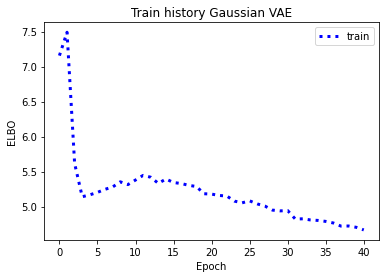

In [230]:
# train VAE
trainer.train(n_epochs=n_epochs, lr=1e-2) 
                                        
elbo_train = trainer.history["elbo_train_set"]
x = np.linspace(0, 100, (len(elbo_train)))
plt.plot(np.log(elbo_train), 
         label="train", color='blue',
         linestyle=':',
         linewidth=3
        )
plt.xlabel('Epoch')
plt.ylabel("ELBO")
plt.legend()
plt.title("Train history Gaussian VAE")
plt.show()

In [231]:
posterior =  trainer.create_posterior(model=vae,
                                      gene_dataset=gene_dataset
                                      )
latent = posterior.get_latent()
latent.shape

(30, 5)

In [232]:
imputed_avg_vae, _ = scvi_baseline_z(tree=tree,
                                 model=vae,
                                 posterior=posterior,
                                 weighted=True,
                                 n_samples_z=1,
                                 gaussian=True
                                )
internal_vae_X = np.array([x for x in imputed_avg_vae.values()]).reshape(-1, ppca.X.shape[1])
internal_vae_X.shape

(29, 50)

***Our Model: CascVI***

In [140]:
import scanpy as sc

adata = AnnData(leaves_X)
adata.obs_names = [n.name for n in list(tree.get_leaves())]
scvi_dataset = AnnDatasetFromAnnData(adata, filtering=False)
scvi_dataset.initialize_cell_attribute('barcodes', adata.obs_names)

#TreeDataset
cas_dataset = TreeDataset(scvi_dataset, tree=tree, filtering=False)
cas_dataset

go
[2021-04-28 00:29:56,208] WARNING - scvi.dataset.dataset | This dataset has some empty cells, this might fail scVI inference.Data should be filtered with `my_dataset.filter_cells_by_count()
[2021-04-28 00:29:56,209] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2021-04-28 00:29:56,210] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2021-04-28 00:29:56,215] INFO - scvi.dataset.dataset | Merging datasets. Input objects are modified in place.
[2021-04-28 00:29:56,216] INFO - scvi.dataset.dataset | Gene names and cell measurement names are assumed to have a non-null intersection between datasets.
[2021-04-28 00:29:56,216] INFO - scvi.dataset.dataset | Keeping 50 genes
[2021-04-28 00:29:56,217] WARNING - scvi.dataset.dataset | X contains continuous and/or negative values. Please use raw UMI/read counts with scVI
[2021-04-28 00:29:56,218] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2021-04-28 00:29:56,219] WARNING - scvi.dataset.d

GeneExpressionDataset object with n_cells x nb_genes = 30 x 50
    gene_attribute_names: 'gene_names'
    cell_attribute_names: 'batch_indices', 'local_vars', 'local_means', 'barcodes', 'labels'
    cell_categorical_attribute_names: 'batch_indices', 'labels'

In [204]:
use_cuda = False
use_MP = True

treevae = GaussianTreeVAE(cas_dataset.nb_genes,
              tree = cas_dataset.tree,
              n_latent=ppca.latent,
              n_hidden=128,
              n_layers=1,
              prior_t = var,
              use_MP=True,
              sigma_ldvae=ppca.sigma_scale
             )

treevae

GaussianTreeVAE(
  (z_encoder): Encoder(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=50, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (mean_encoder): Linear(in_features=128, out_features=5, bias=True)
    (var_encoder): Linear(in_features=128, out_features=5, bias=True)
  )
  (decoder): GaussianLinearDecoder(
    (factor_regressor): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=5, out_features=50, bias=False)
          (1): BatchNorm1d(50, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): None
          (3): None
        )
      )
    )
  )
)

Freezing the decoder

In [205]:
new_weight = torch.from_numpy(ppca.W).float()

with torch.no_grad():
    treevae.decoder.factor_regressor.fc_layers[0][0].weight = torch.nn.Parameter(new_weight)
    
for param in treevae.decoder.factor_regressor.fc_layers[0][0].parameters():
    param.requires_grad = False
    
treevae.decoder

GaussianLinearDecoder(
  (factor_regressor): FCLayers(
    (fc_layers): Sequential(
      (Layer 0): Sequential(
        (0): Linear(in_features=5, out_features=50, bias=False)
        (1): BatchNorm1d(50, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): None
        (3): None
      )
    )
  )
)

In [206]:
assert(treevae.decoder.factor_regressor.fc_layers[0][0].weight.numpy().all() == ppca.W.T.all())

Training

In [207]:
n_epochs = 500
lr = 1e-2
lambda_ = 1.0
freq = 10

tree_trainer = GaussianTreeTrainer(
        model = treevae,
        gene_dataset = cas_dataset,
        lambda_ = lambda_,
        train_size=1.0,
        test_size=0,
        use_cuda=use_cuda,
        frequency=freq,
        n_epochs_kl_warmup=None
    )

train_leaves:  [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22], [23], [24], [25], [26], [27], [28], [29]]
test_leaves:  []
validation leaves:  []


In [208]:
tree_trainer.train(n_epochs=n_epochs,
              lr=lr)

computing elbo
training:   0%|          | 0/500 [00:00<?, ?it/s]Encodings MP Likelihood: 8.131003681077896
Encodings MP Likelihood: 8.844326354857285
Encodings MP Likelihood: 9.964718117689012
Encodings MP Likelihood: 10.681641763850052
Encodings MP Likelihood: 11.228685382514056
Encodings MP Likelihood: 11.377073053954597
Encodings MP Likelihood: 11.525944509606113
Encodings MP Likelihood: 12.185231704495648
Encodings MP Likelihood: 12.632434519493415
Encodings MP Likelihood: 12.215575561024252
computing elbo
training:   2%|▏         | 10/500 [00:00<00:05, 89.32it/s]Encodings MP Likelihood: 13.337037761103117
Encodings MP Likelihood: 13.756606064972466
Encodings MP Likelihood: 13.850765468928655
Encodings MP Likelihood: 13.782055398548113
Encodings MP Likelihood: 13.998498255650775
Encodings MP Likelihood: 13.798194882780281
Encodings MP Likelihood: 13.84153225330457
Encodings MP Likelihood: 13.726199452918337
Encodings MP Likelihood: 13.408866515298822
training:   4%|▍         | 19/5

training:  31%|███▏      | 157/500 [00:01<00:04, 75.31it/s]Encodings MP Likelihood: 10.702949818778896
Encodings MP Likelihood: 10.626264411950917
Encodings MP Likelihood: 11.052627997903262
computing elbo
Encodings MP Likelihood: 10.840582159454645
Encodings MP Likelihood: 10.490520543699388
Encodings MP Likelihood: 10.589626250477032
Encodings MP Likelihood: 10.68913959692565
Encodings MP Likelihood: 10.594278906912457
training:  33%|███▎      | 165/500 [00:02<00:04, 75.60it/s]Encodings MP Likelihood: 10.51759894517536
Encodings MP Likelihood: 10.581415675846758
Encodings MP Likelihood: 10.532155330141519
Encodings MP Likelihood: 10.402270013435247
Encodings MP Likelihood: 10.386957814501793
computing elbo
Encodings MP Likelihood: 10.451570626890652
Encodings MP Likelihood: 10.764718626456753
Encodings MP Likelihood: 10.39703268942651
training:  35%|███▍      | 173/500 [00:02<00:04, 75.83it/s]Encodings MP Likelihood: 10.35964995231251
Encodings MP Likelihood: 10.671964398801602
Encod

Encodings MP Likelihood: 10.208025556794622
Encodings MP Likelihood: 10.33251267271512
Encodings MP Likelihood: 10.355107123568978
Encodings MP Likelihood: 10.441266231931966
Encodings MP Likelihood: 10.41536362814068
Encodings MP Likelihood: 10.366402258623944
training:  64%|██████▎   | 318/500 [00:04<00:02, 75.92it/s]Encodings MP Likelihood: 10.257536898225188
Encodings MP Likelihood: 10.52640315754186
computing elbo
Encodings MP Likelihood: 10.42338964113648
Encodings MP Likelihood: 10.355645194128218
Encodings MP Likelihood: 10.459717555521234
Encodings MP Likelihood: 10.697830686339236
Encodings MP Likelihood: 10.348049843921787
Encodings MP Likelihood: 10.3125052650419
training:  65%|██████▌   | 326/500 [00:04<00:02, 75.70it/s]Encodings MP Likelihood: 10.417370768690166
Encodings MP Likelihood: 10.562231987144763
Encodings MP Likelihood: 10.354065072485565
Encodings MP Likelihood: 10.276576064088555
computing elbo
Encodings MP Likelihood: 10.145226450834048
Encodings MP Likelihoo

training:  94%|█████████▍| 469/500 [00:06<00:00, 79.56it/s]Encodings MP Likelihood: 10.470756938660944
computing elbo
Encodings MP Likelihood: 10.2454911779407
Encodings MP Likelihood: 10.570677236814435
Encodings MP Likelihood: 10.421877443348901
Encodings MP Likelihood: 10.134925632248722
Encodings MP Likelihood: 10.17014114022997
Encodings MP Likelihood: 10.231961119822554
Encodings MP Likelihood: 10.367682145874536
training:  95%|█████████▌| 477/500 [00:06<00:00, 78.26it/s]Encodings MP Likelihood: 10.438444164855575
Encodings MP Likelihood: 10.417331070831189
Encodings MP Likelihood: 10.655424095860395
computing elbo
Encodings MP Likelihood: 10.368005501246653
Encodings MP Likelihood: 10.270845682725794
Encodings MP Likelihood: 10.255557430527098
Encodings MP Likelihood: 10.065034075682915
Encodings MP Likelihood: 10.394973467305183
training:  97%|█████████▋| 485/500 [00:06<00:00, 77.59it/s]Encodings MP Likelihood: 10.369153106336848
Encodings MP Likelihood: 10.160827449077818
Enco

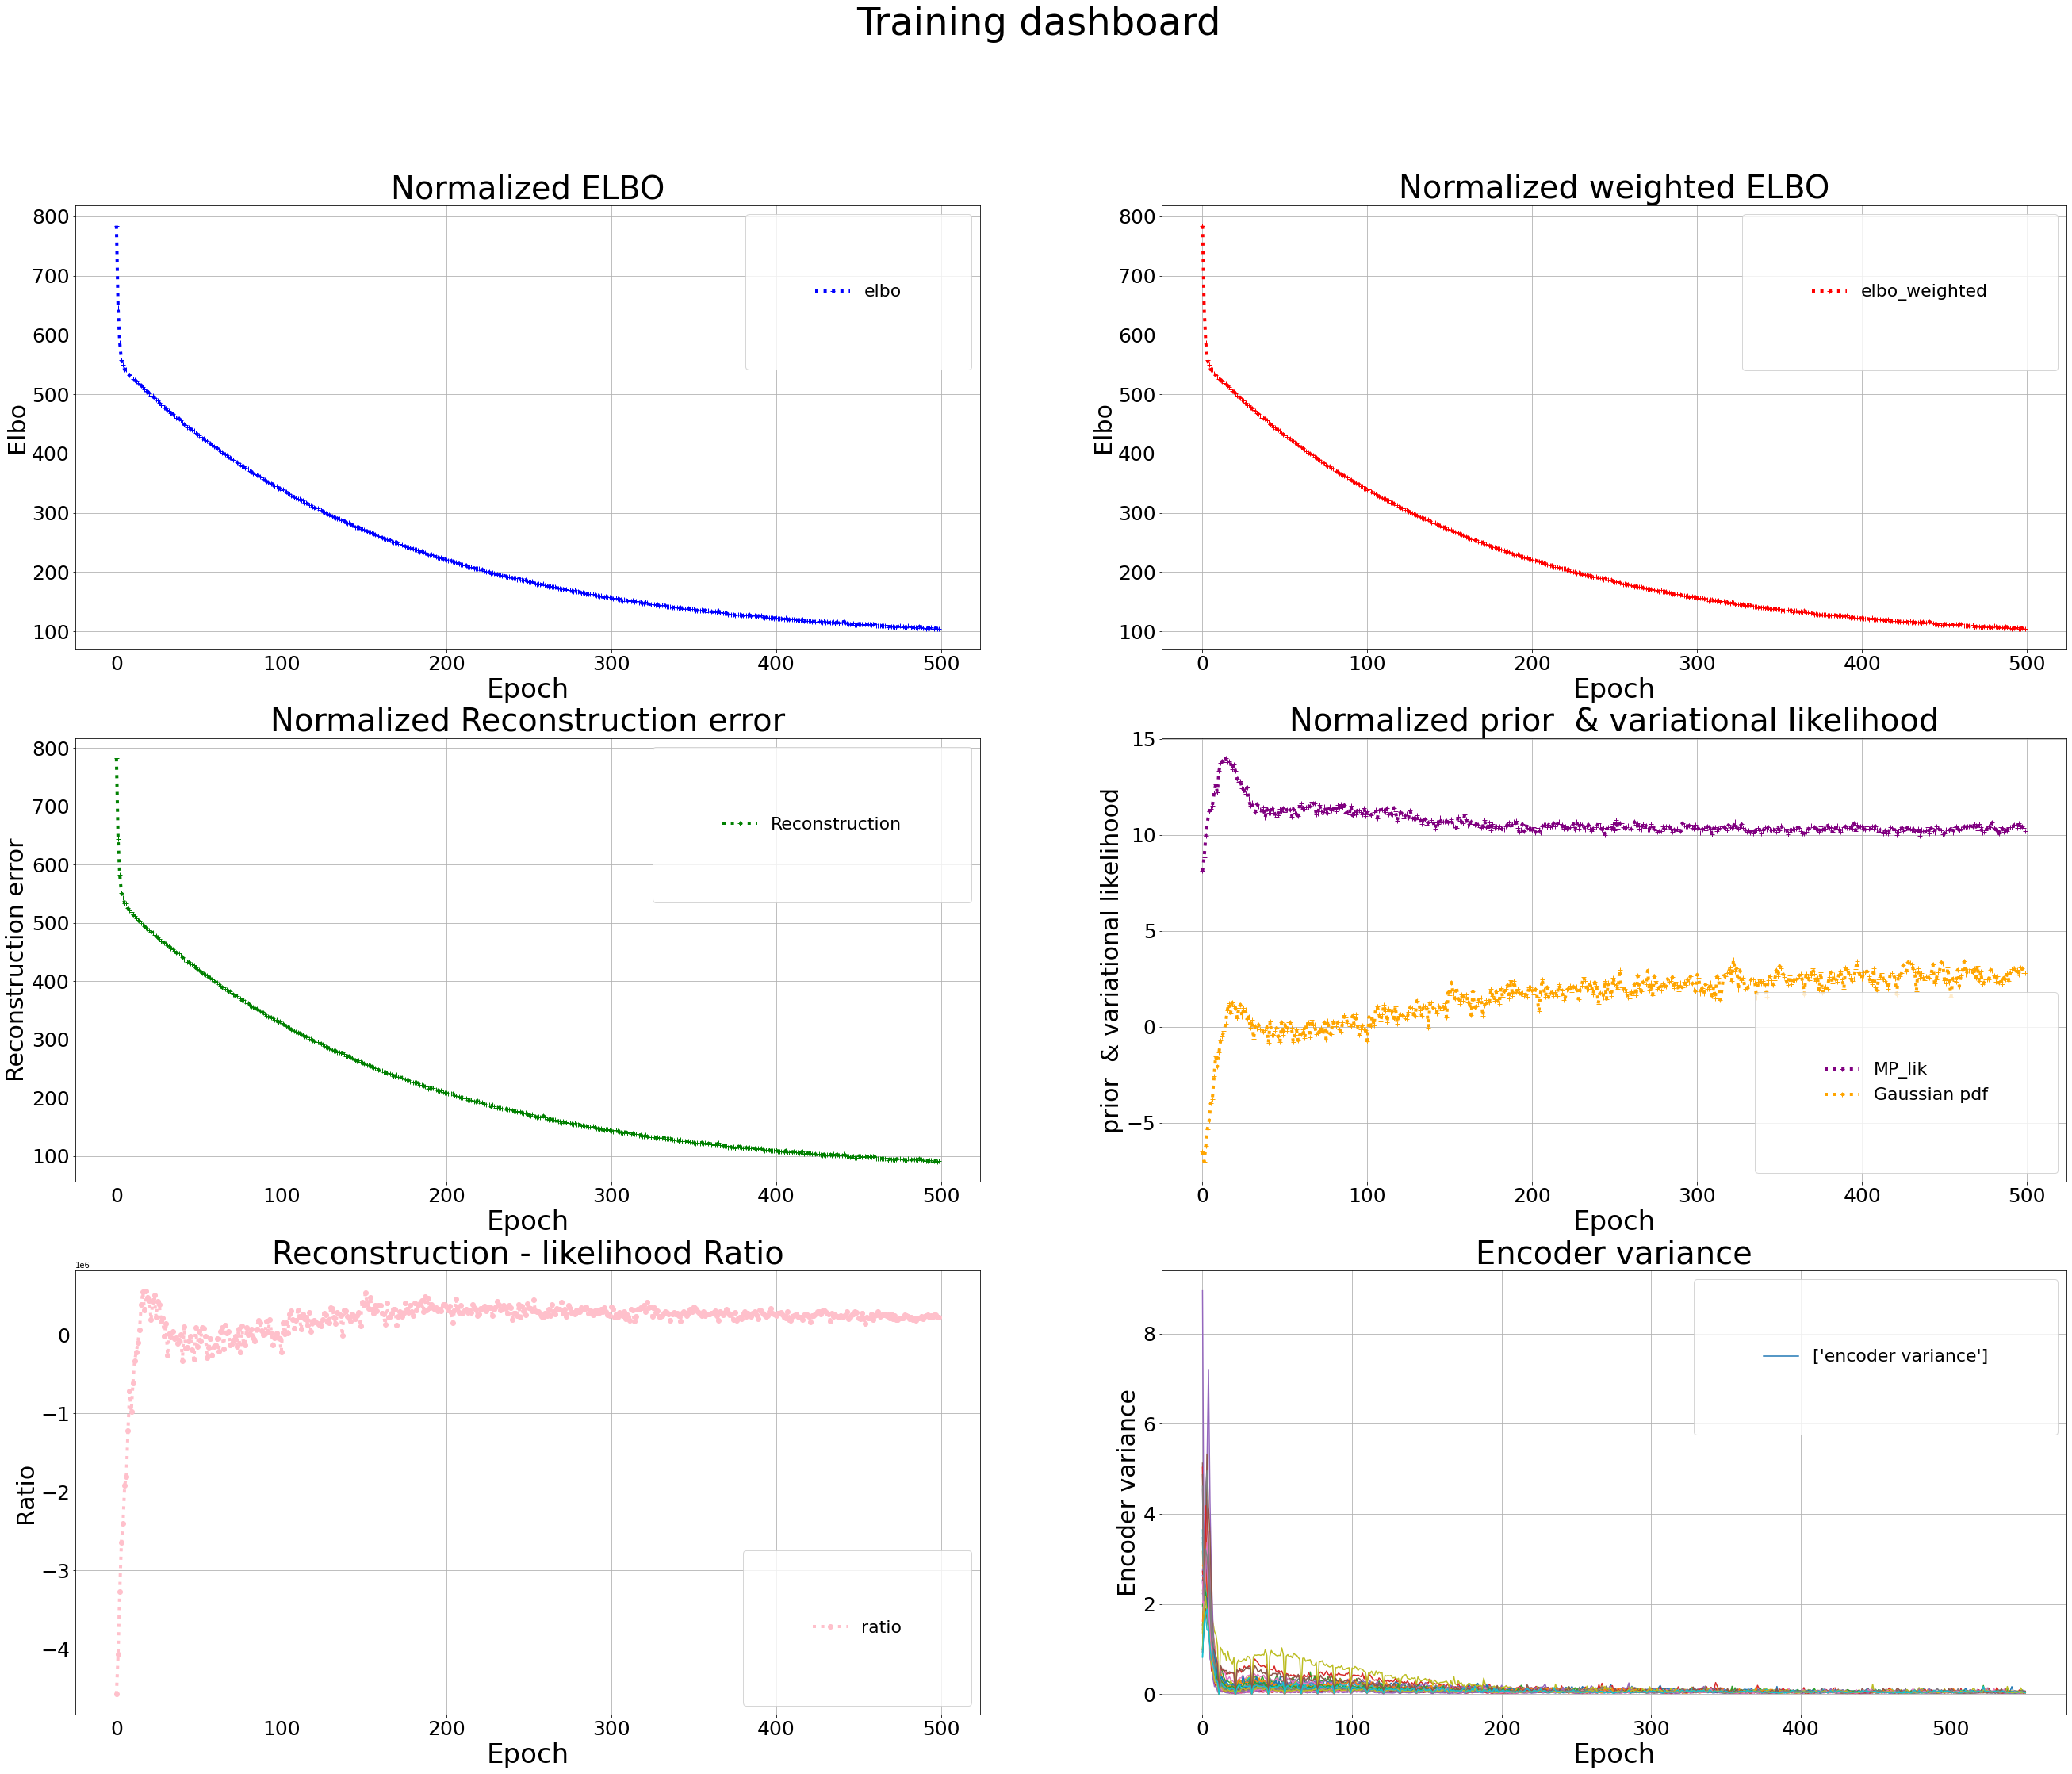

In [209]:
training_dashboard(tree_trainer, treevae.encoder_variance)

In [210]:
tree_posterior = tree_trainer.create_posterior(model=treevae,
                                              gene_dataset=cas_dataset,
                                               clades=tree_trainer.clades,
                                               indices=np.arange(len(cas_dataset))
                                              )
tree_latent = tree_posterior.get_latent()
tree_latent.shape

(30, 5)

Missing Value Imputation

In [211]:
# CascVI imputations
imputed = {}
imputed_z = {}

for n in tree.traverse('levelorder'):
    if not n.is_leaf():
        imputed[n.name], imputed_z[n.name] = tree_posterior.imputation_internal(query_node=n.name,
                                                            give_mean=False,
                                                            pp_averaging=20,
                                                            z_averaging=20                                           
                                                           )

In [212]:
internal_treevae_X = [x for x in imputed.values()]
internal_treevae_X = np.array(internal_treevae_X).reshape(-1, cas_dataset.X.shape[1])

***Evaluation: Correlations***

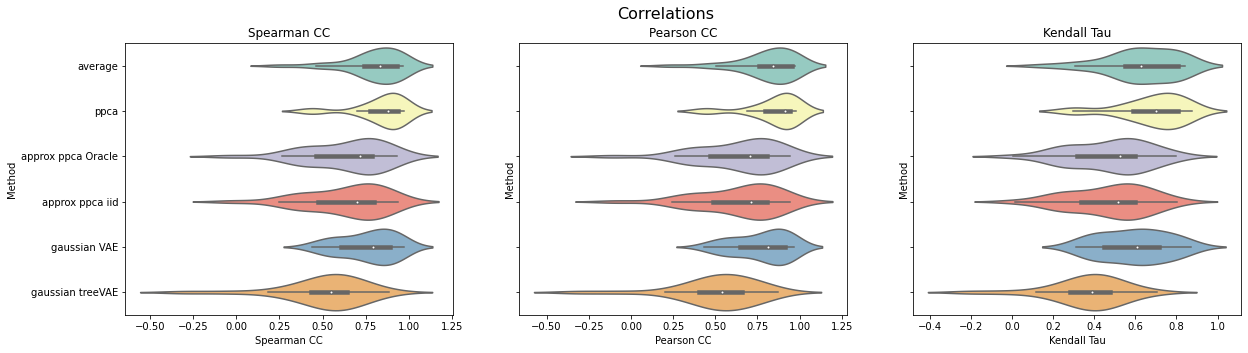

In [254]:
#data = {'groundtruth': internal_X, 'average': internal_avg_X, 'ppca':internal_ppca_X,
#        'approx ppca Oracle':imputed_X, 'approx ppca mean field': imputed_X2,
#        'gaussian VAE': internal_vae_X, 'gaussian treeVAE': internal_treevae_X
#      }

data = {'groundtruth': internal_X.T, 'average': internal_avg_X.T, 'ppca':internal_ppca_X.T,
        'approx ppca Oracle':imputed_X.T, 'approx ppca iid': imputed_X2.T,
        'gaussian VAE': internal_vae_X.T, 'gaussian treeVAE': internal_treevae_X.T
       }

df1 = correlations(data, 'None', True)
df1.head(5)
plt.show()

***Evaluation 2: MSE***

In [255]:
#data = {'groundtruth': internal_X.T, 'average': internal_avg_X.T, 'ppca':internal_ppca_X.T,
#        'approx ppca Oracle':imputed_X.T, 'approx ppca mean field': imputed_X2.T,
#        'gaussian VAE': internal_vae_X.T, 'gaussian treeVAE': internal_treevae_X.T
#       }
data = {'groundtruth': internal_X, 'average': internal_avg_X, 'ppca':internal_ppca_X,
        'approx ppca Oracle':imputed_X, 'approx ppca iid': imputed_X2,
        'gaussian VAE': internal_vae_X, 'gaussian treeVAE': internal_treevae_X
      }

results = mse(data)

In [256]:
results

,average,ppca,approx ppca Oracle,approx ppca iid,gaussian VAE,gaussian treeVAE
MSE,5.817817,3.410567,13.263947,13.200254,18.887101,13.873640
std,3.032727,1.871477,14.063839,13.646959,11.288210,10.132662
